https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing<br><h3>download data from here</h3>

run in collab then transfered data in tensors.numpy() npy

In [2]:
#!pip install tensorflow-io


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio



In [5]:
import os
import matplotlib.pyplot as plt

In [6]:
cap_path=os.path.join('content','/drive/MyDrive/data/data/Parsed_Capuchinbird_Clips/XC114131-0.wav')

nocap_path=os.path.join('content','drive','MyDrive','data','data','Parsed_Not_Capuchinbird_Clips','Crickets-chirping-0.wav')

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
wave = load_wav_16k_mono('/content/drive/MyDrive/data/data/Parsed_Capuchinbird_Clips/XC114131-0.wav')

nwave = load_wav_16k_mono('/content/drive/MyDrive/data/data/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav')

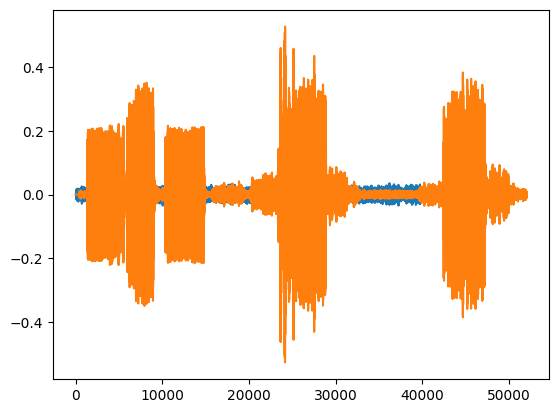

In [9]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [10]:
pos = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data/Parsed_Capuchinbird_Clips/*.wav')
neg = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data/Parsed_Not_Capuchinbird_Clips/*.wav')

In [11]:
pos.as_numpy_iterator().next()

b'/content/drive/MyDrive/data/data/Parsed_Capuchinbird_Clips/XC456236-0.wav'

In [12]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))#Bird
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))#noBird
data = positives.concatenate(negatives)

In [13]:
lengths = []
for file in os.listdir('/content/drive/MyDrive/data/data/Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/data/data/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [14]:
lengths[:10]

[64000, 64000, 56000, 40000, 56000, 48000, 56000, 48000, 64000, 64000]

In [15]:
print(np.mean(lengths),np.min(lengths),np.max(lengths))

54156.66359447005 32000 80000


In [16]:
print(tf.math.reduce_mean(lengths),
tf.math.reduce_min(lengths),
tf.math.reduce_max(lengths))

tf.Tensor(54156, shape=(), dtype=int32) tf.Tensor(32000, shape=(), dtype=int32) tf.Tensor(80000, shape=(), dtype=int32)


In [17]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)#for matching CNN input shape
    return spectrogram, label

In [18]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [19]:
spectrogram, label = preprocess(filepath, label)

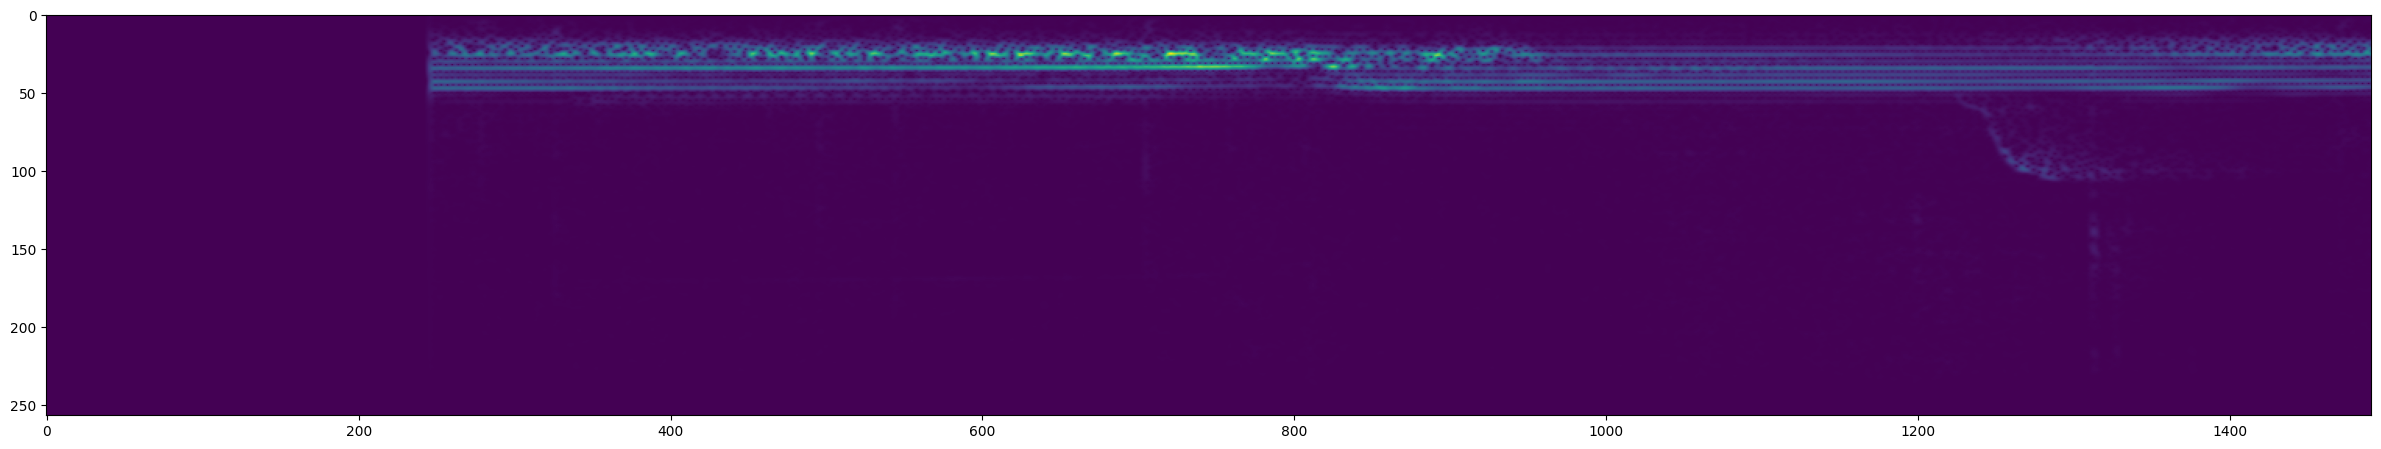

In [20]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [21]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [22]:
train = data.take(36)
test = data.skip(36).take(15)

In [23]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [24]:
labels

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [41]:
print(samples.dtype)


float32


In [50]:
for sample, label in train.take(1):
    print(sample.shape)  # Should be (batch_size, 1491, 257, 1)
    print(label.shape)   # Should be (batch_size,)


(16, 1491, 257, 1)
(16,)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten,MaxPooling2D

In [55]:
model = Sequential()
model.add(tf.keras.layers.Input(shape=(1491,257,1),batch_size=16))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.compile(
    optimizer='Adam',
    loss='BinaryCrossentropy',
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'accuracy']
)

In [59]:
tf.config.run_functions_eagerly(True)


In [57]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (16, 1489, 255, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (16, 744, 127, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (16, 742, 125, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (16, 371, 62, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (16, 368032)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (16, 128)                   │      47,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (16, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,110,833 (179.71 MB)

 Trainable params: 47,110,833 (179.71 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - accuracy: 0.8187 - loss: 1.7855 - precision_5: 0.6641 - recall_5: 0.7958 - val_accuracy: 0.9915 - val_loss: 0.0363 - val_precision_5: 0.9697 - val_recall_5: 1.0000
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.9798 - loss: 0.0496 - precision_5: 0.9811 - recall_5: 0.9544 - val_accuracy: 0.9915 - val_loss: 0.0372 - val_precision_5: 0.9677 - val_recall_5: 1.0000
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9931 - loss: 0.0280 - precision_5: 0.9864 - recall_5: 0.9886 - val_accuracy: 0.9957 - val_loss: 0.0261 - val_precision_5: 1.0000 - val_recall_5: 0.9846
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9992 - loss: 0.0068 - precision_5: 1.0000 - recall_5: 0.9971 - val_accuracy: 1.0000 - val_loss: 0.0050 - val_precision_5: 1.0000 - val_recall_5: 1.0000


In [64]:
hist.history

{'accuracy': [0.8993055820465088,
  0.9861111044883728,
  0.9930555820465088,
  0.9982638955116272],
 'loss': [0.9429976940155029,
  0.046080440282821655,
  0.021111445501446724,
  0.005649264436215162],
 'precision_5': [0.7941176295280457,
  0.9874213933944702,
  0.9866666793823242,
  1.0],
 'recall_5': [0.8544303774833679,
  0.9631901979446411,
  0.9866666793823242,
  0.993630588054657],
 'val_accuracy': [0.9914529919624329,
  0.9914529919624329,
  0.995726466178894,
  1.0],
 'val_loss': [0.0363127775490284,
  0.037157971411943436,
  0.02605411969125271,
  0.004967147950083017],
 'val_precision_5': [0.9696969985961914, 0.9677419066429138, 1.0, 1.0],
 'val_recall_5': [1.0, 1.0, 0.9846153855323792, 1.0]}

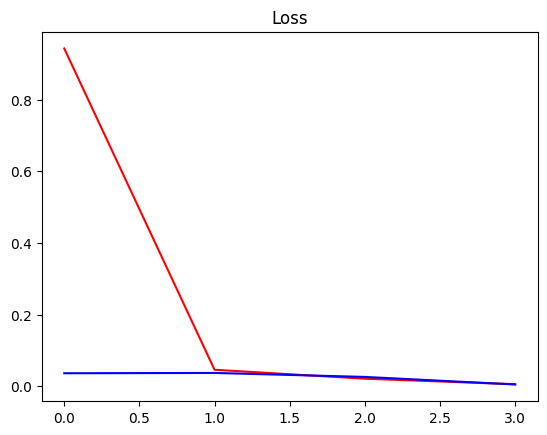

In [61]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

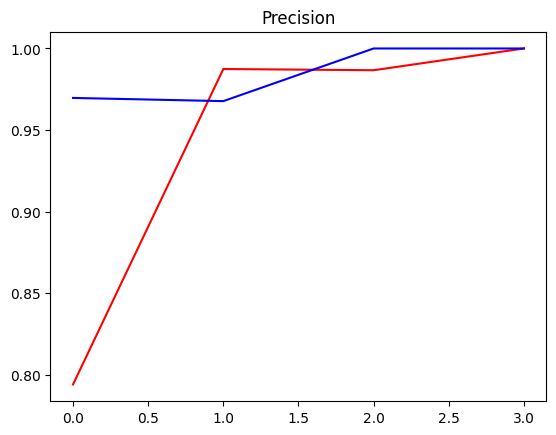

In [68]:
plt.title('Precision')
plt.plot(hist.history['precision_5'], 'r')
plt.plot(hist.history['val_precision_5'], 'b')
plt.show()

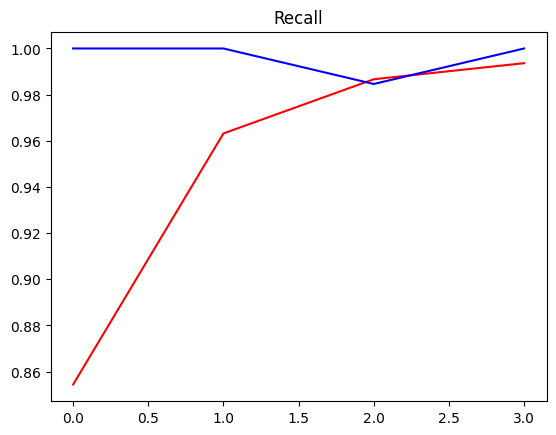

In [67]:
plt.title('Recall')
plt.plot(hist.history['recall_5'], 'r')
plt.plot(hist.history['val_recall_5'], 'b')
plt.show()

In [69]:
x_test,y_test=test.as_numpy_iterator().next()
y_test.shape

(16,)

In [71]:
ypred=model.predict(x_test)
ypred

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


array([[5.0801293e-05],
       [2.1163404e-09],
       [8.7303010e-07],
       [3.3304875e-03],
       [8.2130001e-08],
       [9.9551022e-01],
       [3.4820782e-06],
       [8.5979046e-10],
       [1.8516805e-03],
       [7.3446710e-05],
       [3.2365241e-04],
       [9.9999928e-01],
       [1.7583980e-12],
       [1.0000000e+00],
       [5.3476895e-05],
       [1.0000000e+00]], dtype=float32)

In [73]:
ypred=[1 if pred>0.5 else 0 for pred in ypred]
ypred

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]

In [74]:
y_test.astype(int)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

###now have to test with forest recordings of 3min long of mp3 files

In [80]:
def load_mp3_mono(filename):
    res=tfio.audio.AudioIOTensor(filename)

    tensor=res.to_tensor()
    tensor=tf.math.reduce_sum(tensor,axis=1)/2
    sample_rate=res.rate
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
    return wav

In [81]:
mp3 = os.path.join('/content/drive/MyDrive/data/data/Forest Recordings/recording_00.mp3')
wav = load_mp3_mono(mp3)

In [82]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [83]:
samples, index = audio_slices.as_numpy_iterator().next()

In [84]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [85]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [88]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat[:10]

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [89]:
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls#7 times in forest clip of 3min

7

### Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir('/content/drive/MyDrive/data/data/Forest Recordings'):
    FILEPATH = os.path.join('/content/drive/MyDrive/data/data/Forest Recordings', file)

    wav = load_mp3_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

###Group Consecutive Detections

In [92]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_04.mp3': 4,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_03.mp3': 0,
 'recording_15.mp3': 2,
 'recording_00.mp3': 5,
 'recording_05.mp3': 0,
 'recording_02.mp3': 0,
 'recording_07.mp3': 2,
 'recording_06.mp3': 5,
 'recording_14.mp3': 0,
 'recording_01.mp3': 0,
 'recording_08.mp3': 23,
 'recording_29.mp3': 0,
 'recording_41.mp3': 0,
 'recording_34.mp3': 4,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_37.mp3': 3,
 'recording_28.mp3': 15,
 'recording_16.mp3': 5,
 'recording_39.mp3': 5,
 'recording_18.mp3': 2,
 'recording_31.mp3': 1,
 'recording_36.mp3': 0,
 'recording_21.mp3': 1,
 'recording_35.mp3': 0,
 'recording_26.mp3': 2,
 'recording_24.mp3': 0,
 'recording_23.mp3': 5,
 'recording_30.mp3': 3,
 'recording_22.mp3': 2,
 'recording_27.mp3': 0,
 'recording_32.mp3': 2,
 'recording_17.mp3': 4,
 'recording_42.mp3': 0,
 'recording_38.mp3': 3,
 'recording_40.mp3': 1,
 'recording_25

###export results

In [93]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])